---


Before starting, you must click on the "Copy To Drive" option in the top bar. Go to File --> Save a Copy to Drive. Name it *'LastName_FirstName_T2.5.ipynb'*. <ins>This is the master notebook so you will not be able to save your changes without copying it !</ins> Once you click on that, make sure you are working on that version of the notebook so that your work is saved.



---

### In this tutorial, we will explore a K-Means Clustering model to reliably distinguish between normal data and anomalous data. In the first section, we will see the performance of this model on a simple example. In the second section, we will evaluate the same model on more complex (higher dimensional) data and observe its drawbacks. Finally, in the last section, we will explore a Dimensionality Reduction technique to improve the model's performance.

# K-means Clustering for Anomaly Detection

We will first import the required libraries:


1.   [seaborn](https://seaborn.pydata.org/) - statistical data visualization in Python
2.   [numpy](https://numpy.org/) - scientific computing in Python
3.   [matplotlib](https://matplotlib.org/) - visualization of data in Python



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# 1. K-means for Anomaly Detection - Example 1

K-means clustering is a simple and useful unsupervised learning algorithm. The goal of K-means clustering is to group similar data points into a set number (K) of groups. The algorithm does this by identifying 'centroids', which are the centers of clusters, and then allocating data points to the nearest cluster. You can read more about this machine learning technique [here](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1).

### Generate Training Data
Let's try a simple example where we generate clustered data and fit a K-Means model on the data. You could imagine these clusters as different stages of NORMAL operation of a machine.

We import the following:


1.    from sklearn.datasets import [make_blobs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) - Generates Gaussian blobs for clustering.



In [ ]:
from sklearn.datasets import make_blobs

In the below cell, we generate 300 data samples and assign them to 3 different clusters. We then visualize the data in 2 dimensions.

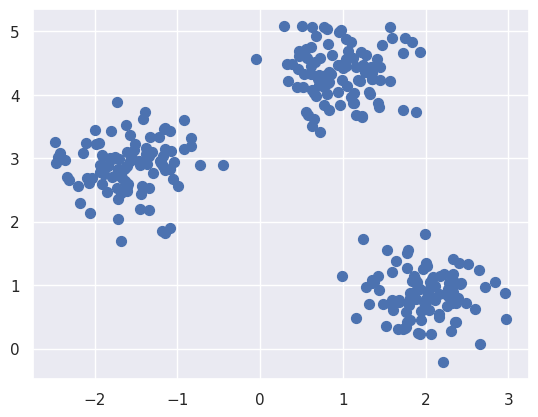

In [ ]:
num_centers = 3
X_train, y_train_true = make_blobs(n_samples=300, centers=num_centers,
                                   cluster_std=0.40, random_state=0)


plt.scatter(X_train[:, 0], X_train[:, 1], s=50);

### Observe Data and Ground Truth array shapes

In [ ]:
print(X_train.shape)
print(y_train_true.shape)

(300, 2)
(300,)


### Define K-Means model

Now let's use [SKLearn's KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) algorithm to fit to the data. This does a lot of the work for us, but if you would like to learn more about the underlying process check out the [wikipedia page](https://en.wikipedia.org/wiki/K-means_clustering#Algorithms)

We import the following:


1.  [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) - free software machine learning library for Python.




In [ ]:
from sklearn.cluster import KMeans

We define our K-Means model for a fixed number of clusters and then fit it to our X_train data samples. Notice, we don't fit the model on the ground truth values (y_true) - **Unsupervised Learning**.

In [ ]:
kmeans = KMeans(n_clusters=num_centers)        # we select three clusters

kmeans.fit(X_train)                            # we fit the centroids to the data
y_train_kmeans = kmeans.predict(X_train)       # we determine the closest centroid for each datapoint

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now let's visualize the results. Each datapoint is color-coded according to the centroid they correspond to, and the centroids themselves are shown as black circles.


*Note:* The predictions displayed through color of clusters.

[[-1.58104795  2.87850514]
 [ 1.98615163  0.8556712 ]
 [ 0.96292805  4.34943942]]



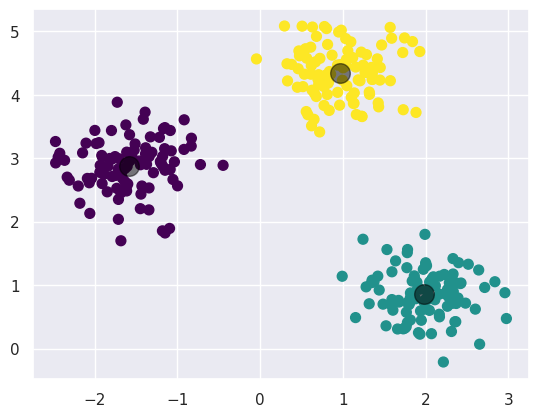

In [ ]:
# plotting clusters
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train_kmeans, s=50, cmap='viridis')

# centroid locations
centers = kmeans.cluster_centers_
print(centers)
print()

# plotting centroids
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

Looks like K-means does a great job in this simple example! Now let's explore how we can use this for anomaly detection.



---


**Question 1**: Write down in layman's terms the steps involved in K-Means Clustering Algorithm.

**Answer:** calculate the distance between each data point and a centroid to assign it to a cluster

---

### K-Means for Anomaly Detection
Below we introduce two new clusters (orange) that weren't part of our training data. We will pretend all of these are anomalies for the sake of a simple example.

One of these clusters is completely different from the data we've seen before and another is only slightly different. We can easily (visually) separate one of the clusters, but the other one overlaps slightly with one of our training clusters. Given the low dimensionality of the data, it's reasonable that some new data is impossible to distinguish from the training data.

In the below cell, we generate 300 new data samples and assign them to 2 different clusters. We then visualize the anomalous data along with original training dataset.

Text(0.5, 1.0, 'Original Training Data and Anomalous Data')

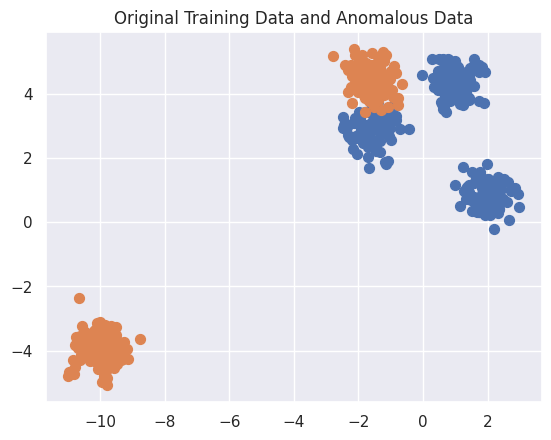

In [ ]:
X_anomaly, y_anomaly_true = make_blobs(n_samples=300, centers=2,
                       cluster_std=0.40, random_state=1)

# plotting train dataset
plt.scatter(X_train[:, 0], X_train[:, 1], s=50)

# plotting anomalous dataset
plt.scatter(X_anomaly[:,0], X_anomaly[:,1], s=50)

plt.title("Original Training Data and Anomalous Data")

### Define a boundary to differentiate between Normal and Anomalous Data

We will calculate the 99th percentile distance for each cluster's centroid which will act as a threshold to determine if a data sample is normal or anomalous.

In the cells below, we will determine this threshold for each centroid using our training dataset (normal data).

First we will calculate the distance between each cluster's centroid and its corresponding cluster's data samples. To do this, we first find the distance of all 300 points to each centroid. This is done using the `kmeans.transform()` API. You can read more about the API [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans.transform). We then assign the 300 points to a cluster (0, 1, or 2) based on its minimum distance to the centroid. For eg: if sample 40 has the following distances to the three centroids - [0.8, 0.6, 0.7], it will be assigned to cluster 1.  


In [ ]:
# distances of each of the 300 training samples from each of the 3 centroids
train_distances = kmeans.transform(X_train)
print("train_distance shape:", train_distances.shape)
print()


# distances of the 300 points from its closest centroid
center_distances = {key: [] for key in range(num_centers)}      # {0: [distances...], 1: [distances...], 2: [distances...]}

for i in range(len(y_train_kmeans)):  # 300
  cluster_number = y_train_kmeans[i]
  min_distance = train_distances[i][cluster_number]
  #print(min_distance)

  # min_distance2 = np.min(train_distances[i])
  # print(min_distance2)

  center_distances[cluster_number].append(min_distance)


print("No. data samples close to centroid 1 (Cluster 1):", len(center_distances[0]))
print("No. data samples close to centroid 2 (Cluster 2):", len(center_distances[1]))
print("No. data samples close to centroid 3 (Cluster 3):", len(center_distances[2]))

train_distance shape: (300, 3)

No. data samples close to centroid 1 (Cluster 1): 100
No. data samples close to centroid 2 (Cluster 2): 100
No. data samples close to centroid 3 (Cluster 3): 100





We then calculate the 99 percentile distance for each centroid that was observed in the training data. We use the 99 percentile distance here since our training data could have some outliers.

These distances will act as a boundary, beyond which we will classify datapoints as anomalies. The percentile can be adjusted to be more or less sensitive depending on the application and the training data.

In [ ]:
percentile_threshold = 99


# out of 100 data samples, it finds the 2nd max (or max among 99 samples) distance.
center_99percentile_distance = dict()
for key in center_distances.keys():      # 3
    center_99percentile_distance[key] = np.percentile(center_distances[key], percentile_threshold)

    # print(center_distances[key])
    # print(np.max(center_distances[key]))
    # print()


print()
print("99 Percentile distance for each centroid:",center_99percentile_distance)


99 Percentile distance for each centroid: {0: 1.1415867080723232, 1: 1.0917976541677412, 2: 1.0315363528478958}


### Visualization of boundary
Now let's plot those normal/abnomal boundaries on our training data to see how well they encompass our training data. We will also plot in yellow the points in our training data that are being classified as abnormal.

To draw the circles, we use the `plt.Circle()` API. You can read more about the API [here](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Circle.html).

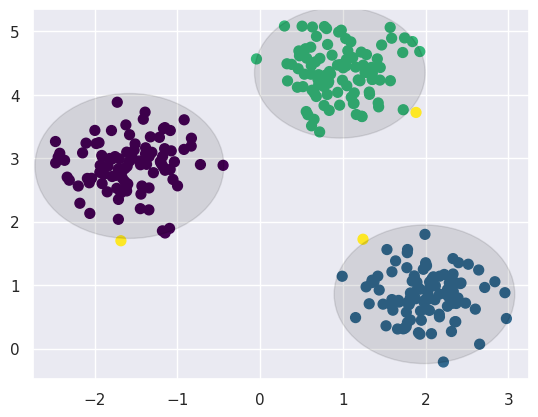

In [ ]:
fig, ax = plt.subplots()

colors = []
for i in range(len(X_train)):
  min_distance = train_distances[i][y_train_kmeans[i]]
  cluster_num = y_train_kmeans[i]
  if (min_distance > center_99percentile_distance[cluster_num]):
    colors.append(3)
  else:
    colors.append(cluster_num)


ax.scatter(X_train[:, 0], X_train[:, 1], c=colors, s=50, cmap='viridis')

# draw circles
for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]), center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)

---


**Question 2**: What is the role of the 99th percentile distance in the above plot (plt.Circle API)?

**Answer:**  We drew a circle around the point that falls under 99th percentile.

---

### Classifying Test Data
Now let's add in the abnormal test data to see how it's classified. We first get our predictions of the anomalous dataset using our trained model 'kmeans'.

In [ ]:
y_anomaly_kmeans = kmeans.predict(X_anomaly)

Then we combine the training data samples and testing data samples to visualize all samples on one plot.

In [ ]:
# distances of each of the 300 testing samples from each of the 3 centroids
anomaly_distances = kmeans.transform(X_anomaly)



#combine all the data
combined_distances = [*train_distances, *anomaly_distances]
combined_y = [*y_train_kmeans, *y_anomaly_kmeans]
all_data = np.array([*X_train, *X_anomaly])


We iterate through all data samples (normal and anomalous) and classify them based on their distance from the closest centroid. Here, we consider a data sample being classified as anomalous as positive.

Normal datapoints misclassified as abnormal:  3
Abnormal datapoints misclassified as normal:  17


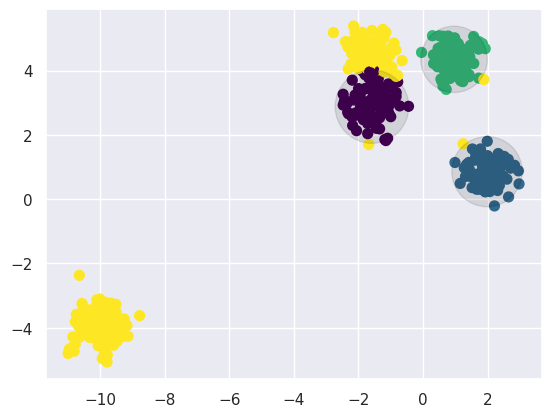

In [ ]:
fig, ax = plt.subplots()

false_neg=0
false_pos=0

colors = []
for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  cluster_num = combined_y[i]

  if (min_distance > center_99percentile_distance[cluster_num]):   # anomalous - positive
    colors.append(3)  # any 4th color
    if (i<300):       # training data is the first 300 elements in the combined list
      false_pos+=1

  else:               # normal - negative
    colors.append(cluster_num)
    if (i>=300):      # anomalous data is the last 300 elements in the combined list
      false_neg+=1


# cluster colors based on 'colors' array
ax.scatter(all_data[:, 0], all_data[:, 1], c=colors, s=50, cmap='viridis')


# plotting circles (boundaries)
for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]), center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)



print('Normal datapoints misclassified as abnormal: ', false_pos)             # abnormal assumed as positive
print('Abnormal datapoints misclassified as normal: ', false_neg)

Our simple model did a pretty good job!

Now we have a way to classify abnormal data in a simple two dimension space. You can adjust the `percentile_treshold` variable to see how that impacts the number of false positives and false negatives.

Now let's see how well this applies to data with more dimensions.

---


**Question 3**: Can you think of a scenario each for when a high false positve value and a high false negative value are bad?

**Answer:**

---

# 2. K-means for Anomaly Detection on Digits - Example 2



First we load in our dataset of **64** pixel images of numerical digits (think MNIST in 8x8 pixel images), **a much higher dimmension** than our 2-D problem we were dealing with earlier. The digits range from 0 - 9. We will treat digits 0 and 1 as abnormal and digits 2 - 9 as normal.

### Load Dataset

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
print(digits.data.shape)    # there are 1797 train examples - 64 features each

(1797, 64)


Since we consider 8 classes as normal (digits 2 - 9) we will assume 8 clusters for each normal label.

In [ ]:
normal_data = []
abnormal_data = []

normal_label = []
abnormal_label = []

num_clusters = 8

#separate our data arbitrarily into normal (2-9) and abnormal (0-1)
for i in range(len(digits.target)):
  if digits.target[i] < 10-num_clusters:      # digits 0 and 1
    abnormal_data.append(digits.data[i])
    abnormal_label.append(digits.target[i])
  else:                                       # digits 2 - 9
    normal_data.append(digits.data[i])
    normal_label.append(digits.target[i])

### Inspect Data and Label Shapes

In [ ]:
normal_data_np = np.array(normal_data)
normal_label_np = np.array(normal_label)
abnormal_data_np = np.array(abnormal_data)
abnormal_label_np = np.array(abnormal_label)

print("normal data shape:", normal_data_np.shape)
print("normal label shape:", normal_label_np.shape)
print("abnormal data shape:", abnormal_data_np.shape)
print("abnormal data shape:", abnormal_label_np.shape)

normal data shape: (1437, 64)
normal label shape: (1437,)
abnormal data shape: (360, 64)
abnormal data shape: (360,)


### Define Model
Next we find our 8 cluster centers/centroids (from normal data)

In [ ]:
# instantiate model
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# train model on normal data
kmeans.fit(normal_data)
y_normal = kmeans.predict(normal_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Visualization of Centroids
We observe below that the shape of each centroid is (1, 64) corresponding to the 64 pixels/features of the image.

In [ ]:
print(kmeans.cluster_centers_.shape)

(8, 64)


Next let's visualize the centers/centroids that K-means found for each cluster. We see that K-means is able to find clusters whose centers are recognizable digits. A bit blury, but still recognizable to the human eye!

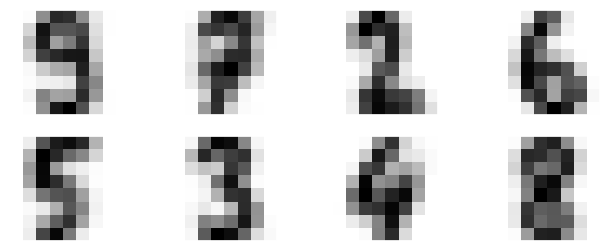

In [ ]:
fig, ax = plt.subplots(2, int(num_clusters/2), figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(num_clusters, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

### Define a boundary to differentiate between Normal and Anomalous Data
First we will calculate the distance between each cluster's centroid and its corresponding cluster's data samples. To do this, we first find the distance of all 1437 normal data points (classes 2-9) to each centroid. This is done using the `kmeans.transform()` API. We then assign the 1437 points to a cluster (0 - 7) based on its minimum distance to the centroid. For eg: if sample 470 has the following distances to the eight centroids - [21.2, 21.4, 21.6, 21.8, **21.1**, 21.3, 21.5, 21.7], it will be assigned to cluster 4.  



In [ ]:
# distances of each of the 1437 normal training samples from each of the 8 centroids
normal_distances = kmeans.transform(normal_data) # < YOUR CODE HERE >
print(normal_distances.shape)


center_distances = {key: [] for key in range(num_clusters)}
for i in range(len(y_normal)):
  cluster_num = y_normal[i]
  min_distance = normal_distances[i][cluster_num]
  center_distances[cluster_num].append(min_distance)

# print(center_distances)

(1437, 8)


**Hint:** Use `kmeans.transform(normal_data)`

Now let's find the 99 percentile boundary for these clusters as we did in the previous example. This will help us define the boundary to differentiate between normal and abnormal data samples.

In [ ]:
percentile_treshold = 99


# out of 1437 data samples, it finds the 2nd max (or max among 1436 samples) distance.
center_99percentile_distance = dict()
for key in center_distances.keys():
    center_99percentile_distance[key] = np.percentile(center_distances[key], percentile_threshold)

    # print(center_distances[key])
    # print(np.max(center_distances[key]))
    # print()


print(center_99percentile_distance)

{0: 39.91689814057058, 1: 40.4457496790435, 2: 34.48686817044241, 3: 33.49012149177819, 4: 36.042201290733075, 5: 36.35108790416124, 6: 38.30619421761721, 7: 39.65958713422169}


### Classifying Test Data
Now lets get the distance to each centroid for our anomalous data and combine it with our normal data. Then we can classify everything as either normal or abnormal based on the distances we calculated previously.

We will first get our predictions for the anomalous data.

In [ ]:
y_abnormal = kmeans.predict(abnormal_data)

Then we combine the training data samples and testing data samples to visualize all samples on one plot.

In [ ]:
# distances of each of the 360 testing samples from each of the 8 centroids
abnormal_distances = kmeans.transform(abnormal_data)


#combine all the data
combined_distances = [*normal_distances, *abnormal_distances]
combined_y = [*y_normal, *y_abnormal]
normal_data_length = len(normal_data)
all_data = np.array([*normal_data, *abnormal_data])



false_neg=0
false_pos=0

colors = []
for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  cluster_num = combined_y[i]

  if (min_distance > center_99percentile_distance[cluster_num]):   # anomalous - positive
    if (i<normal_data_length):       # training data is the first 1437 elements in the combined list
      false_pos+=1

  else:               # normal - negative
    if (i>=normal_data_length):      # anomalous data is the last 360 elements in the combined list
      false_neg+=1



print('Normal datapoints misclassified as abnormal: ', false_pos)             # abnormal assumed as positive
print('Abnormal datapoints misclassified as normal: ', false_neg)

Normal datapoints misclassified as abnormal:  18
Abnormal datapoints misclassified as normal:  297


---


**Question 4**: Why aren't we visualizing the clusters here?

**Answer:**

---

The results are ok but not ideal. We can try adjusting the `percentile_treshold` variable to get better results. However, generally, K-means doesn't scale well with increased dimensionality. This example is still very low dimensional compared to many real world use cases and it still has a significant impact on our accuracy. This relationship is called the [***Curse of Dimensionality***](https://en.wikipedia.org/wiki/Curse_of_dimensionality) which plagues many conventional machine learning algorithms.

**Next we will explore how to improve our K-means results with some pre-processing.**

# 3. Dimensionality Reduction

To combat the ***Curse of Dimensionality*** we can try projecting our data into a low dimensional space.

We can use the t-distributed stochastic neighbor embedding ([t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)) algorithm, to pre-process the data before feeding it into K-means. t-SNE is used to visualize high dimensional data and we can use it to reduce the dimensionality of our input data which will hopefully lead to better results!

First we will run TSNE on all of our data (normal and abnormal) and later split it into our train (normal) and test (abnormal) data. This is becasue t-SNE is a transductive learner and is not intended to transform data beyond what it is trained on. There are some recent [implementations](https://github.com/kylemcdonald/Parametric-t-SNE) of a [parametric t-sne algorithm](https://lvdmaaten.github.io/publications/papers/AISTATS_2009.pdf) that can acomplish this but they are not included in sklearn.

We project our data from 64 dimensions to 2 dimensions!

In [ ]:
from sklearn.manifold import TSNE

# Project the data to two dimensions: this step will take several seconds

# instantiating tSNE with 2-dimensional data
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)        # transform on all classes (0 -9)
print(digits_proj.shape)

(1797, 2)


### Visualization of data after Dimensionality Reduction
We visualize our transformed data and observe that we have nicely separated two dimension data (down from our 64 pixel images)! This looks a lot more like the clusters in the first example.

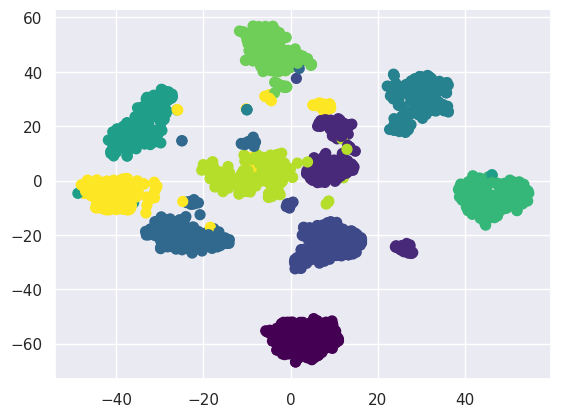

In [ ]:
#Visualize our new data
fig, ax = plt.subplots()
ax.scatter(digits_proj[:, 0], digits_proj[:, 1],c=digits.target, s=50, cmap='viridis')



Next, we separate the data into normal and abnormal just like the previous example.

In [ ]:
normal_data = []
abnormal_data = []

normal_label = []
abnormal_label = []

num_clusters = 8

#separate our data arbitrarily into normal (2-9) and abnormal (0-1)
for i in range(len(digits.target)):
  if digits.target[i]<10-num_clusters:
    abnormal_data.append(digits_proj[i])
    abnormal_label.append(digits.target[i])
  else:
    normal_data.append(digits_proj[i])
    normal_label.append(digits.target[i])

Now run K-means and calculate our percentile threshold.

In [ ]:
# Compute the clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(normal_data)
y_normal = kmeans.predict(normal_data)


# distances of each of the 1437 normal training samples from each of the 8 centroids
normal_distances = kmeans.transform(normal_data)
print(normal_distances.shape)


center_distances = {key: [] for key in range(num_clusters)}
for i in range(len(y_normal)):
  min_distance = normal_distances[i][y_normal[i]]
  center_distances[y_normal[i]].append(min_distance)


percentile_threshold = 99
# out of 1437 data samples, it finds the 2nd max (or max among 1436 samples) distance.
center_99percentile_distance = dict()
for key in center_distances.keys():
    center_99percentile_distance[key] = np.percentile(center_distances[key], percentile_threshold)

    # print(center_distances[key])
    # print(np.max(center_distances[key]))
    # print()

print()
print(center_99percentile_distance)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(1437, 8)

{0: 11.765791789714108, 1: 20.564414733308976, 2: 14.687096663768779, 3: 9.936348446486843, 4: 13.298115809420839, 5: 20.039431652614812, 6: 15.358522412862174, 7: 9.755720035196443}


Finally we calculate the distances of our abnormal data to our cluster centers. Then count the number of false negatives and false positives and plot all the data.

Normal datapoints misclassified as abnormal:  16
Abnormal datapoints misclassified as normal:  51


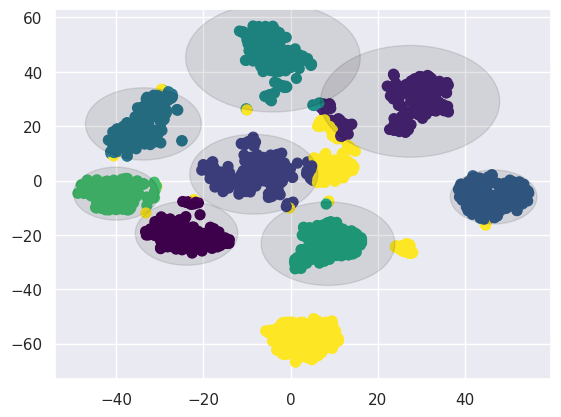

In [ ]:
y_abnormal = kmeans.predict(abnormal_data)
abnormal_distances = kmeans.transform(abnormal_data)

#combine all the data
combined_distances = [*normal_distances, *abnormal_distances]
combined_y = [*y_normal, *y_abnormal]
normal_data_length = len(normal_data)
all_data = np.array([*normal_data, *abnormal_data])



false_neg=0
false_pos=0
colors = []

for i in range(len(all_data)):
  min_distance = combined_distances[i][combined_y[i]]
  cluster_num = combined_y[i]

  if (min_distance > center_99percentile_distance[cluster_num]):   # anomalous - positive
    colors.append(10)  # any 4th color
    if (i<normal_data_length):       # training data is the first 1437 elements in the combined list
      false_pos+=1

  else:               # normal - negative
    colors.append(cluster_num)
    if (i>=normal_data_length):      # anomalous data is the last 360 elements in the combined list
      false_neg+=1



fig, ax = plt.subplots()
ax.scatter(all_data[:, 0], all_data[:, 1], c=colors, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
for i in range(len(centers)):
  circle = plt.Circle((centers[i][0], centers[i][1]),center_99percentile_distance[i], color='black', alpha=0.1);
  ax.add_artist(circle)

print('Normal datapoints misclassified as abnormal: ', false_pos)
print('Abnormal datapoints misclassified as normal: ', false_neg)

We've reduced the number of abnormal points being misclassified as normal!!

Unfortunately, while dimensionality reduction can be a power tool, it's not always a viable option. Algorithms like t-SNE can take a long time to run and won't always produce useful results.

## Additional Readings
If you would like to learn about using reconstruction with K-means for anomaly detection check out: http://amid.fish/anomaly-detection-with-k-means-clustering